In [4]:
latex_dir = 'LaTex/img/'
EXPORT_FOR_LATEX = True

def plot_images(plot, figname=None):
    if EXPORT_FOR_LATEX:
        plt.savefig(latex_dir+figname+'.pdf', bbox_inches='tight')
    else:
        plot.show()

In [5]:
import pymc3 as pm
import pandas as pd
import loc_df = pd.read_csv('data/islands_locations.csv')
loc_df.Tmatplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from theano import shared


In [6]:
class Normalizer:
    def __init__(self, variable):
        self.mean = variable.mean()
        self.sd = variable.std()
        self.norm_data = (variable-self.mean)/self.sd
    
    def normalize(self, variables):
        return ((variables)-self.mean)/self.sd
    
    def denormalize(self,variables):
        return np.array(variables)*self.sd+self.mean
    
def inference_denorm(m_normed, variables):
    denorm_vars = np.zeros(len(variables))
    for j,m in enumerate(m_normed):
        denorm_vars[j] = normed[m].denormalize(variables[j])
    return pd.DataFrame(denorm_vars, index = m_normed).T

def inference_norm(m_normed, variables):
    norm_vars = np.zeros(len(variables))
    for j,m in enumerate(m_normed):
        norm_vars[j] = normed[m].normalize(variables[j])
    return pd.DataFrame(norm_vars, index = m_normed).T

In [7]:
islands = pd.read_csv('data/galapagos.csv',sep=';')
islands['LOG_AREA']=np.log(1+islands['AREA'])
normed = {}
for to_norm in ['ELEV','NATIVE','LOG_AREA','TOTAL','DISTNEAR','DISTSC']:
    normed[to_norm] = Normalizer(islands[to_norm])
    islands['NORM_'+to_norm]=normed[to_norm].norm_data

islands.head()

ISLAND  TOTAL  NATIVE   AREA  ELEV  DISTNEAR     DISTSC    AREANEAR  \
0     Baltra     58      23  25.09   332       0.6   0.600000    1.840000   
1  Bartolome     31      21   1.24   109       0.6  26.299999  572.330017   
2   Caldwell      3       3   0.21   114       2.8  58.700001    0.780000   
3   Champion     25       9   0.10    46       1.9  47.400002    0.180000   
4    Coamano      2       1   1.05   130       1.9   1.900000  903.820007   

   LOG_AREA  NORM_ELEV  NORM_NATIVE  NORM_LOG_AREA  NORM_TOTAL  NORM_DISTNEAR  \
0  3.261552  -0.086414    -0.129524       0.304948   -0.237570      -0.662714   
1  0.806476  -0.615819    -0.203538      -0.665837   -0.473104      -0.662714   
2  0.190620  -0.603949    -0.869661      -0.909359   -0.717361      -0.508594   
3  0.095310  -0.765382    -0.647620      -0.947046   -0.525445      -0.571643   
4  0.717840  -0.565965    -0.943675      -0.700886   -0.726085      -0.571643   

   NORM_DISTSC  
0    -0.828675  
1    -0.450913  
2     0.025331  
3    -0.140766  
4    -0.809566

In [8]:
loc_df = pd.read_csv('data/islands_locations.csv')
loc_df.T

0          1         2         3        4             5   \
ISLAND    Baltra  Bartolome  Caldwell  Champion  Coamano  Daphne Major   
lat    -0.459667  -0.284296  -1.31542   -1.2379   -0.759     -0.422435   
lon     -90.2714   -90.5506  -90.3386  -90.3859 -90.2786       -90.372   

                  6        7        8        9     ...           20  \
ISLAND  Daphne Minor   Darwin     Eden  Enderby    ...       Rabida   
lat        -0.394844  1.67869  -0.5599  -1.2321    ...    -0.417199   
lon         -90.3516 -92.0041 -90.5372  -90.363    ...     -90.7105   

                   21            22          23        24           25  \
ISLAND  San Cristobal  San Salvador  Santa Cruz  Santa Fe  Santa Maria   
lat         -0.867472     -0.261984   -0.639359 -0.819877     -1.30833   
lon          -89.4364      -90.7153    -90.3372  -90.0653     -90.4314   

              26       27       28        29  
ISLAND   Seymour  Tortuga     Wolf  Wspanola  
lat    -0.396022 -1.00944  1.38361  -1.37584  
lon     -90.2878 -90.8711  -91.816  -89.6722  

[3 rows x 30 columns]

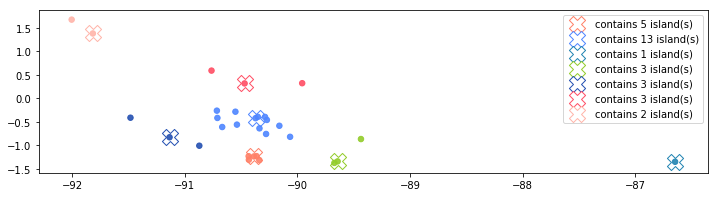

In [9]:
from sklearn.cluster import DBSCAN, AffinityPropagation

colors = ['#FF8168','#4F86FF','#2284B2','#93CC2B', '#2551B2','#FF4F65','#FFB5AA',]

knn = AffinityPropagation(damping=.5)
clustered = knn.fit_predict(loc_df[['lat','lon']].as_matrix())

loc_df['cluster']= clustered
n_isl = np.unique(clustered, return_counts=True)

plt.figure(figsize=(12,3))
colors_list = [colors[c] for c in clustered]
for j, center in enumerate(knn.cluster_centers_):
    plt.scatter(center[1], center[0], label='contains '+str(n_isl[1][j])+' island(s)', 
                  marker='X', s=260, color='white', edgecolors=colors[j])

plt.legend()
plt.scatter(loc_df['lon'], loc_df['lat'], c=colors_list, alpha=.9, s=30)
plt.show()

In [10]:
import gmaps
import gmaps.datasets
gmaps.configure(api_key=open('data/gmap_api_key/gmap_api.txt','r').read()) # Your Google API key

locations = gmaps.datasets.load_dataset("starbucks_kfc_uk")
locations = [(a[0],a[1]) for a in  loc_df[['lat','lon']].as_matrix()]
info = loc_df.ISLAND.values
fig = gmaps.figure()
isl_layer = gmaps.symbol_layer(locations, fill_color=colors_list, stroke_color=colors_list, scale=2, info_box_content=info)
fig.add_layer(isl_layer)
fig

A Jupyter Widget

In [11]:
data_isl = islands.merge(loc_df, on='ISLAND', )

N_TEST = 6
test_ix = np.arange(len(islands))
np.random.seed(242)

np.random.shuffle(test_ix)
data_isl_train = data_isl.drop(islands.index[test_ix[:N_TEST]])
data_isl_oos = data_isl.iloc[test_ix[:N_TEST]]

data_isl_oos

ISLAND  TOTAL  NATIVE        AREA  ELEV  DISTNEAR      DISTSC  \
25    Santa Fe     62      28   24.080000   259      16.5   16.500000   
18       Pinta    104      37   59.560001   777      29.1  119.599998   
0       Baltra     58      23   25.090000   332       0.6    0.600000   
24  Santa Cruz    444      95  903.820007   864       0.6    0.000000   
28     Tortuga     16       8    1.240000   186       6.8   50.900002   
17      Onslow      2       2    0.010000    25       3.3   45.900002   

      AREANEAR  LOG_AREA  NORM_ELEV  NORM_NATIVE  NORM_LOG_AREA  NORM_TOTAL  \
25    0.520000  3.222071  -0.259717     0.055510       0.289336   -0.202676   
18  129.490005  4.103635   0.970022     0.388572       0.637923    0.163711   
0     1.840000  3.261552  -0.086414    -0.129524       0.304948   -0.237570   
24    0.520000  6.807736   1.176561     2.534969       1.707178    3.129697   
28   17.950001  0.806476  -0.433020    -0.684627      -0.665837   -0.603956   
17    0.100000  0.009950  -0.815236    -0.906668      -0.980799   -0.726085   

    NORM_DISTNEAR  NORM_DISTSC       lat        lon  cluster  
25       0.451150    -0.594962 -0.819877 -90.065334        1  
18       1.333834     0.920494  0.591950 -90.762788        5  
0       -0.662714    -0.828675 -0.459667 -90.271394        1  
24      -0.662714    -0.837494 -0.639359 -90.337189        1  
28      -0.228377    -0.089320 -1.009443 -90.871088        4  
17      -0.473567    -0.162815 -1.233333 -90.433333        0

# full pooling:

In [12]:
log_area_s = shared(data_isl['NORM_LOG_AREA'].values)

with pm.Model() as model_pooled:
    a = pm.Normal('a',0,2)
    intercept = pm.Normal('int',0,2)
    sigma = pm.HalfCauchy('sigma',1)
    y = pm.Normal('y', observed = data_isl['NORM_NATIVE'].values, 
                  mu=intercept+a*log_area_s,
                  sd=sigma)

    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:01<00:00, 1814.13it/s]


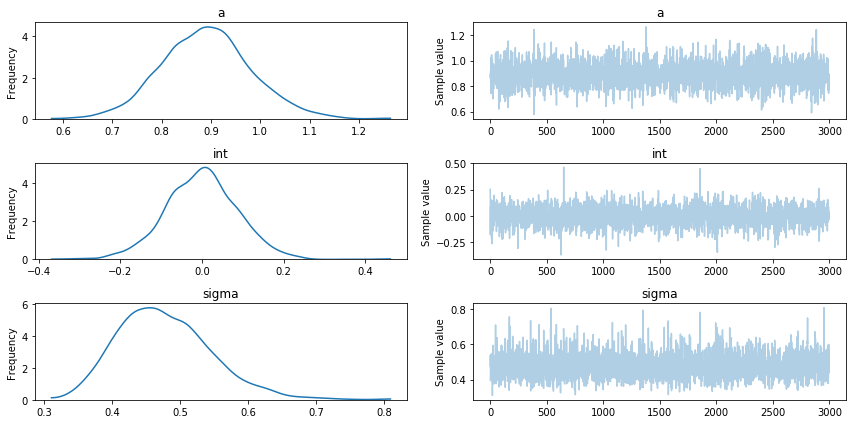

In [13]:
pm.traceplot(trace)
plt.show()

In [15]:
plt.figure(figsize=(12,4))
for i in np.arange(len(trace['a']))[2000:2300]:
    z=np.linspace(-2,3,2)
    plt.plot(z,trace['a'][i]*z+trace['int'][i], color='#2E317F', alpha=.01)
colors_list = [colors[c] for c in data_isl.cluster]
plt.scatter(data_isl['NORM_NATIVE'].values,data_isl['NORM_LOG_AREA'].values, marker='1', label='observed data', c=colors_list)
plt.xlabel('normalized log(area island)')
plt.ylabel('normalized native species')
plt.xlim(z)
plt.legend()
plot_images(plt, '4_27') 

In [16]:
cl_data = data_isl.sort_values(by='cluster').reset_index(drop=True)
colors_list = [colors[c] for c in cl_data.cluster]
w_0 = trace['int'].mean(axis=0)
w_1 = trace['a'].mean(axis=0)

plt.figure(figsize=(12,4))
plt.suptitle('predicted vs effective number of species per island', y=.949)
plt.scatter(np.arange(len(cl_data)),normed['NATIVE'].denormalize(w_0+w_1*cl_data.NORM_LOG_AREA), c=colors_list)
plt.scatter(np.arange(len(data_isl)),cl_data.NATIVE, c='black', alpha=.2, marker='1', label='actual values')

plt.xticks(range(len(cl_data.ISLAND.values)), cl_data.ISLAND.values, rotation=-90)
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors_list,ax.xaxis.get_ticklabels())]

plt.hlines(normed['NATIVE'].denormalize(w_0+w_1*cl_data.NORM_LOG_AREA.mean()),-1,len(data_isl)+1, 
           linestyles="--", linewidth=1, alpha=.2, label='mean predicted value')
plt.ylim((None,120))
plt.legend(loc=2, framealpha=0)
plt.show()

In [17]:
errors = np.square(w_0+w_1*cl_data.NORM_LOG_AREA-cl_data.NORM_NATIVE)
plt.figure(figsize=(12,4))
plt.suptitle('normalized squared error term', y=.949)
plt.scatter(np.arange(len(cl_data)),errors, c=colors_list)
plt.xticks(range(len(cl_data.ISLAND.values)), cl_data.ISLAND.values, rotation=-90)
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors_list,ax.xaxis.get_ticklabels())]
plt.hlines(errors.mean(),-1,len(data_isl)+1, linestyles="--", linewidth=1, alpha=.2, label='average nMSE')
plt.ylim((None, 1.5))
plt.legend(loc=2, framealpha=0)
plt.show()

# non-pooled

In [18]:
log_area_s = shared(data_isl['NORM_LOG_AREA'].values)
cluster_s = shared(data_isl['cluster'].values)
N_clusters = len(data_isl['cluster'].unique())

with pm.Model() as model_no_pooling:
    a = pm.Normal('a',0,2, shape=N_clusters)
    intercept = pm.Normal('int',0,2, shape=N_clusters)
    sigma = pm.HalfCauchy('sigma',1)
    y = pm.Normal('y', observed = data_isl['NORM_NATIVE'].values, 
                  mu=intercept[cluster_s]+a[cluster_s]*log_area_s,
                  sd=sigma)

    trace_np = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:07<00:00, 482.06it/s]


In [19]:
pm.traceplot(trace_np)
plt.show()

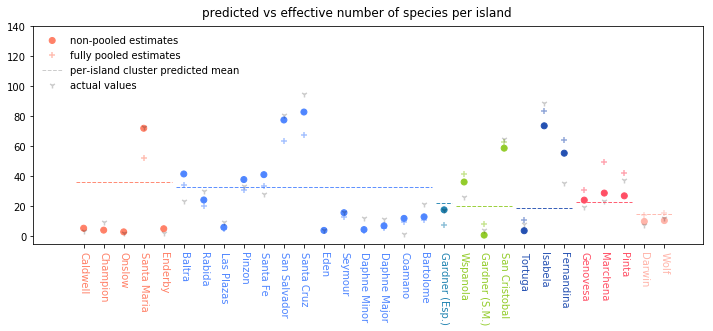

In [22]:
cl_data = data_isl.sort_values(by='cluster').reset_index(drop=True)
cl = cl_data.cluster
colors_list = [colors[c] for c in cl]
w_0_np = trace_np['int'].mean(axis=0)
w_1_np = trace_np['a'].mean(axis=0)
cl_breakp = np.hstack([0,np.unique(cl_data.cluster, return_counts=True)[1].cumsum()])

plt.figure(figsize=(12,4))
plt.suptitle('predicted vs effective number of species per island', y=.949)
plt.scatter(np.arange(len(cl_data)),normed['NATIVE'].denormalize(w_0_np[cl]+w_1_np[cl]*cl_data.NORM_LOG_AREA), 
            c=colors_list, label='non-pooled estimates')
plt.scatter(np.arange(len(cl_data)),normed['NATIVE'].denormalize(w_0+w_1*cl_data.NORM_LOG_AREA),
            c=colors_list, marker='+', alpha=.5, label='fully pooled estimates')

plt.xticks(range(len(cl_data.ISLAND.values)), cl_data.ISLAND.values, rotation=-90)
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors_list,ax.xaxis.get_ticklabels())]

for clust in range(N_clusters):
    mean = normed['NATIVE'].denormalize(w_0_np[clust]+w_1_np[clust]*cl_data.NORM_LOG_AREA.mean())
    plt.hlines(mean,cl_breakp[clust]-.4,cl_breakp[clust+1]-.6, 
           linestyles="--", linewidth=1, alpha=.9, label=None, color=colors[clust])
plt.hlines(0,-1,-1, linestyles="--", linewidth=1, label='per-island cluster predicted mean', alpha=.2)
plt.scatter(np.arange(len(data_isl)),cl_data.NATIVE, c='black', alpha=.2, marker='1', label='actual values')
plt.ylim((None,140))
plt.legend(loc=2, framealpha=0)
plot_images(plt, '4_28') 

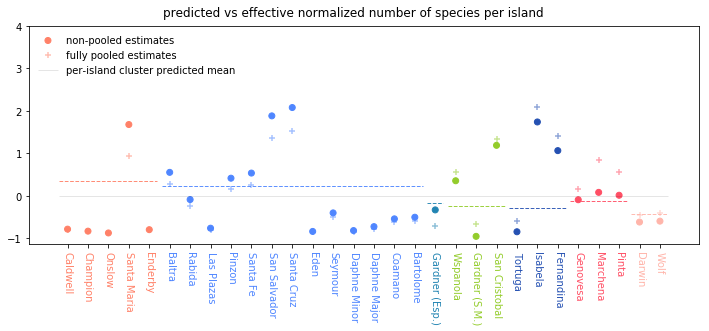

In [30]:
cl_data = data_isl.sort_values(by='cluster').reset_index(drop=True)
cl = cl_data.cluster
colors_list = [colors[c] for c in cl]
w_0_np = trace_np['int'].mean(axis=0)
w_1_np = trace_np['a'].mean(axis=0)
cl_breakp = np.hstack([0,np.unique(cl_data.cluster, return_counts=True)[1].cumsum()])

plt.figure(figsize=(12,4))
plt.suptitle('predicted vs effective normalized number of species per island', y=.949)
plt.scatter(np.arange(len(cl_data)),w_0_np[cl]+w_1_np[cl]*cl_data.NORM_LOG_AREA, c=colors_list, label='non-pooled estimates')
plt.scatter(np.arange(len(cl_data)),w_0+w_1*cl_data.NORM_LOG_AREA,
            c=colors_list, marker='+', alpha=.5, label='fully pooled estimates')

plt.xticks(range(len(cl_data.ISLAND.values)), cl_data.ISLAND.values, rotation=-90)
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors_list,ax.xaxis.get_ticklabels())]

for clust in range(N_clusters):
    mean = w_0_np[clust]+w_1_np[clust]*cl_data.NORM_LOG_AREA.mean()
    plt.hlines(mean,cl_breakp[clust]-.4,cl_breakp[clust+1]-.6, 
           linestyles="--", linewidth=1, alpha=.9, label=None, color=colors[clust])
plt.hlines(0,-.4,29.4, linestyles="solid", linewidth=1, label='per-island cluster predicted mean', alpha=.1)
#plt.scatter(np.arange(len(data_isl)),cl_data.NORM_NATIVE, c='black', alpha=.2, marker='x', label='actual values')
plt.ylim((None,4))
plt.legend(loc=2, framealpha=0)
plt.show()

In [31]:
errors_np = np.square((w_0_np[cl]+w_1_np[cl]*cl_data.NORM_LOG_AREA)-cl_data.NORM_NATIVE)
plt.figure(figsize=(12,4))
plt.suptitle('normalized squared error term for pooled vs non-pooled', y=.949)
plt.scatter(np.arange(len(cl_data)),errors_np, c=colors_list, label = 'non-pooled errors')
plt.scatter(np.arange(len(cl_data)),errors, c=colors_list, marker= '+', alpha=.5, label = 'fully pooled errors')
plt.xticks(range(len(cl_data.ISLAND.values)), cl_data.ISLAND.values, rotation=-90)
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors_list,ax.xaxis.get_ticklabels())]
plt.hlines(errors_np.mean(),-1,len(data_isl)+1, linestyles=":", linewidth=1, alpha=.4, label='average non-pooled nMSE', color='darkred')
plt.hlines(errors.mean(),-1,len(data_isl)+1, linestyles="--", linewidth=1, alpha=.2, label='average fully pooled nMSE')

plt.ylim((None, 1.5))
plt.legend(loc=2, framealpha=0)
plot_images(plt, '4_29') 

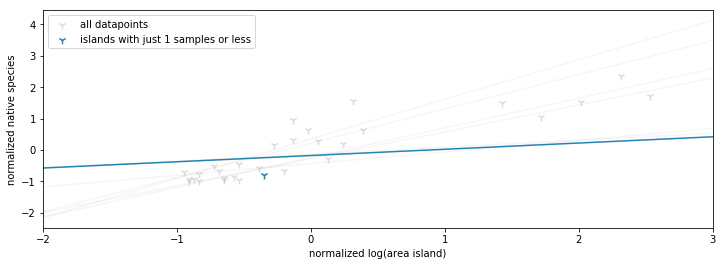

In [25]:
N_SMALL = 2
small_clusters = data_isl.cluster.value_counts()[data_isl.cluster.value_counts() < N_SMALL]
few_sample_isl = data_isl[data_isl.cluster.isin(small_clusters.index)]


plt.figure(figsize=(12,4))
z=np.linspace(-2,3,2)
colors_list = [colors[c] for c in data_isl.cluster]

for i in range(N_clusters):
    plt.plot(z,w_0_np[i]+w_1_np[i]*z, color='darkgrey', alpha=.1)
plt.scatter(data_isl['NORM_NATIVE'].values,data_isl['NORM_LOG_AREA'].values, marker='1', label='all datapoints', c='darkgrey', alpha=.4,s = 60)

for i in small_clusters.index:
    plt.plot(z,w_0_np[i]+w_1_np[i]*z, color=colors[i], alpha=1)
plt.scatter(few_sample_isl['NORM_NATIVE'].values,few_sample_isl['NORM_LOG_AREA'].values, marker='1', 
            label='islands with just '+str(N_SMALL-1)+' samples or less', c=[colors[c] for c in few_sample_isl.cluster], alpha=1,s = 60)

plt.xlabel('normalized log(area island)')
plt.ylabel('normalized native species')
plt.xlim(z)
plt.legend()
plt.show()

# partial pooling

In [26]:
log_area_s = shared(data_isl['NORM_LOG_AREA'].values)
cluster_s = shared(data_isl['cluster'].values)
N_clusters = len(data_isl['cluster'].unique())

with pm.Model() as model_partial_pooling:
    hyper_mu_a = pm.Normal('hm_a',0,1)
    hyper_sd_a = pm.Uniform('hs_a',0,10)
    hyper_mu_int = pm.Normal('hm_int',0,1)
    hyper_sd_int = pm.Uniform('hs_int',0,10)

    a = pm.Normal('a',hyper_mu_a,hyper_sd_a, shape=N_clusters)
    intercept = pm.Normal('int',hyper_mu_int,hyper_sd_int, shape=N_clusters)
    sigma = pm.HalfCauchy('sigma',1)
    y = pm.Normal('y', observed = data_isl['NORM_NATIVE'].values, 
                  mu=intercept[cluster_s]+a[cluster_s]*log_area_s,
                  sd=sigma)

    trace_pp = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████████████████████████████████████████████▉| 3499/3500 [00:11<00:00, 299.97it/s]C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 60 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:11<00:00, 299.89it/s]


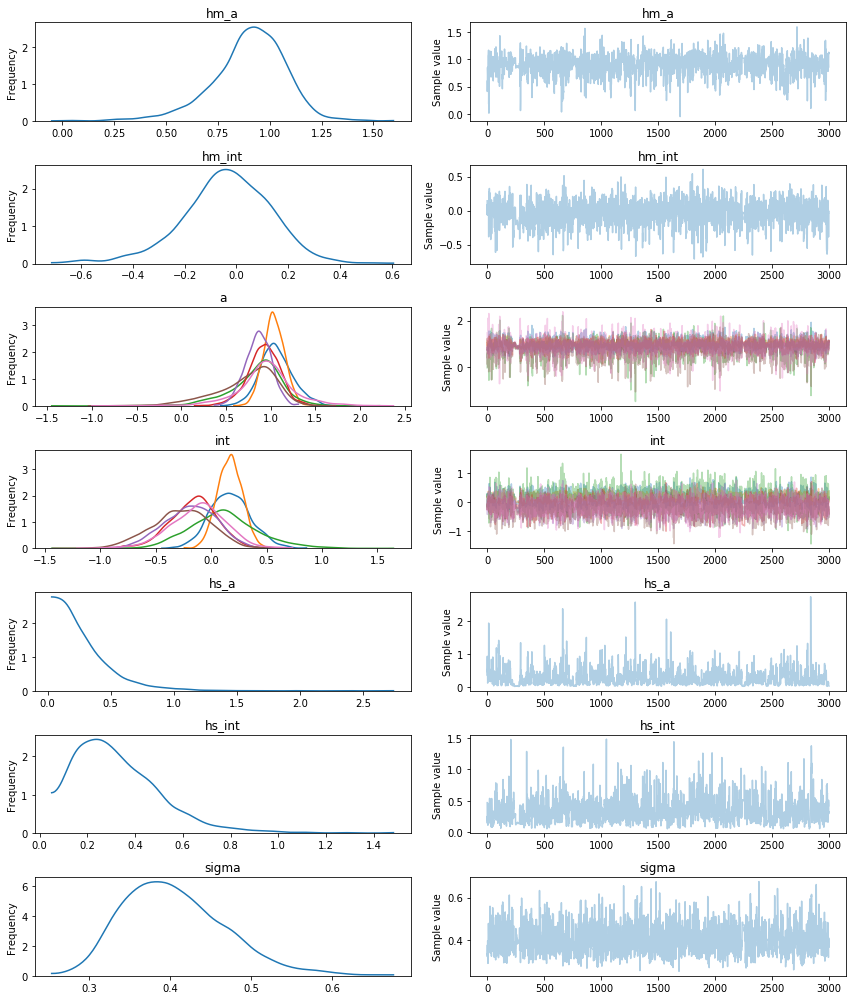

In [27]:
pm.traceplot(trace_pp)
plt.show()

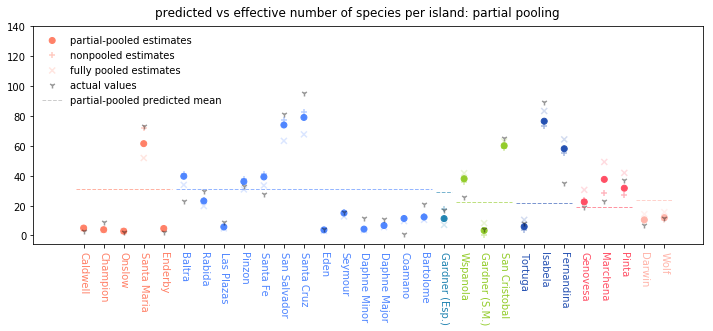

In [28]:
cl_data = data_isl.sort_values(by='cluster').reset_index(drop=True)
cl = cl_data.cluster
colors_list = [colors[c] for c in cl]
w_0_pp = trace_pp['int'].mean(axis=0)
w_1_pp = trace_pp['a'].mean(axis=0)
cl_breakp = np.hstack([0,np.unique(cl_data.cluster, return_counts=True)[1].cumsum()])

plt.figure(figsize=(12,4))
plt.suptitle('predicted vs effective number of species per island: partial pooling', y=.949)
plt.scatter(np.arange(len(cl_data)),normed['NATIVE'].denormalize(w_0_pp[cl]+w_1_pp[cl]*cl_data.NORM_LOG_AREA), c=colors_list, label='partial-pooled estimates')
plt.scatter(np.arange(len(cl_data)),normed['NATIVE'].denormalize(w_0_np[cl]+w_1_np[cl]*cl_data.NORM_LOG_AREA),
            c=colors_list, marker='+', alpha=.4, label='nonpooled estimates')
plt.scatter(np.arange(len(cl_data)),normed['NATIVE'].denormalize(w_0+w_1*cl_data.NORM_LOG_AREA),
            c=colors_list, marker='x', alpha=.2, label='fully pooled estimates')
plt.scatter(np.arange(len(data_isl)),cl_data.NATIVE, c='black', alpha=.4, marker='1', label='actual values')

plt.xticks(range(len(cl_data.ISLAND.values)), cl_data.ISLAND.values, rotation=-90)
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors_list,ax.xaxis.get_ticklabels())]

for clust in range(N_clusters):
    mean = normed['NATIVE'].denormalize(w_0_pp[clust]+w_1_pp[clust]*cl_data.NORM_LOG_AREA.mean())
    plt.hlines(mean,cl_breakp[clust]-.4,cl_breakp[clust+1]-.6, 
           linestyles="--", linewidth=1, alpha=.6, label=None, color=colors[clust])
    
plt.hlines(0,-1,-1, linestyles="--", linewidth=1, label='partial-pooled predicted mean', alpha=.2)
plt.ylim((None,140))
plt.legend(loc=2, framealpha=0)
plot_images(plt, '4_30') 

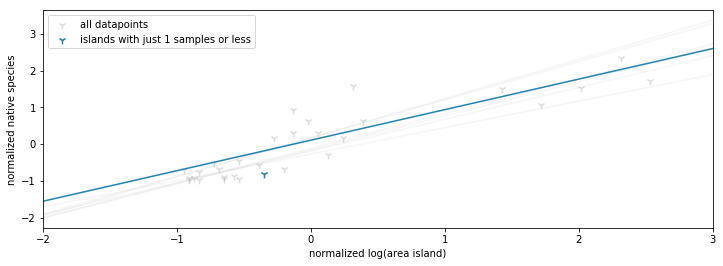

In [33]:
N_SMALL = 2
small_clusters = data_isl.cluster.value_counts()[data_isl.cluster.value_counts() < N_SMALL]
few_sample_isl = data_isl[data_isl.cluster.isin(small_clusters.index)]


plt.figure(figsize=(12,4))
z=np.linspace(-2,3,2)
colors_list = [colors[c] for c in data_isl.cluster]

for i in range(N_clusters):
    plt.plot(z,w_0_pp[i]+w_1_pp[i]*z, color='darkgrey', alpha=.1)
plt.scatter(data_isl['NORM_NATIVE'].values,data_isl['NORM_LOG_AREA'].values, marker='1', label='all datapoints', c='darkgrey', alpha=.4,s = 60)

for i in small_clusters.index:
    plt.plot(z,w_0_pp[i]+w_1_pp[i]*z, color=colors[i], alpha=1)
plt.scatter(few_sample_isl['NORM_NATIVE'].values,few_sample_isl['NORM_LOG_AREA'].values, marker='1', 
            label='islands with just '+str(N_SMALL-1)+' samples or less', c=[colors[c] for c in few_sample_isl.cluster], alpha=1,s = 60)

plt.xlabel('normalized log(area island)')
plt.ylabel('normalized native species')
plt.xlim(z)
plt.legend()
plot_images(plt, '4_31') 

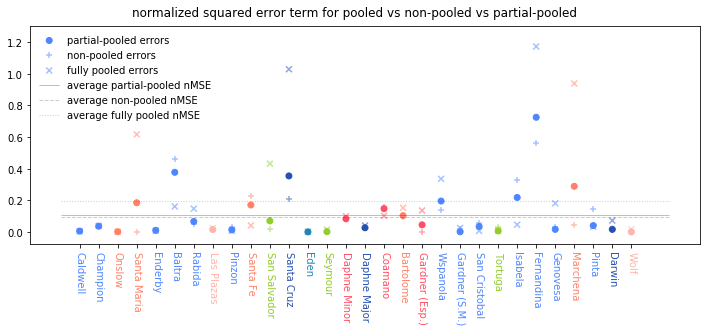

In [34]:
errors_pp = np.square((w_0_pp[cl]+w_1_pp[cl]*cl_data.NORM_LOG_AREA)-cl_data.NORM_NATIVE)
plt.figure(figsize=(12,4))
plt.suptitle('normalized squared error term for pooled vs non-pooled vs partial-pooled', y=.949)
plt.scatter(np.arange(len(cl_data)),errors_pp, c=colors_list, label = 'partial-pooled errors')
plt.scatter(np.arange(len(cl_data)),errors_np, c=colors_list, marker= '+', alpha=.5, label = 'non-pooled errors')
plt.scatter(np.arange(len(cl_data)),errors, c=colors_list, marker= 'x', alpha=.5, label = 'fully pooled errors')

plt.xticks(range(len(cl_data.ISLAND.values)), cl_data.ISLAND.values, rotation=-90)
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors_list,ax.xaxis.get_ticklabels())]
    
plt.hlines(errors_pp.mean(),-1,len(data_isl)+1, linestyles="solid", linewidth=1, alpha=.3, label='average partial-pooled nMSE', color='darkred')
plt.hlines(errors_np.mean(),-1,len(data_isl)+1, linestyles="--", linewidth=1, alpha=.2, label='average non-pooled nMSE')
plt.hlines(errors.mean(),-1,len(data_isl)+1, linestyles=":", linewidth=1, alpha=.2, label='average fully pooled nMSE')

plt.ylim((None, 1.3))
plt.legend(loc=2, framealpha=0)
plot_images(plt, '4_32') 

# model comparison:

In [36]:
traces = [trace,trace_np,trace_pp]
pm_models = [model_pooled,model_no_pooling,model_partial_pooling]
models = ['fully pooled', 'non-pooled', 'partial-pooled']

comparison = pm.compare(traces,pm_models)
models_ix = [models[a] for a in comparison.index]
comparison.index = models_ix

dic_loo = pd.DataFrame([[pm.dic(traces[i],pm_models[i]) for i in range(len(traces))],
              [pm.loo(traces[i],pm_models[i])[0] for i in range(len(traces))]], 
                       columns=models, index=['DIC','loo']).T

pd.merge(comparison, dic_loo, left_index=True, right_index=True)

C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


WAIC  pWAIC dWAIC weight    SE   dSE warning        DIC  \
partial-pooled  40.14   8.41     0   0.46  8.26     0       1  67.167622   
fully pooled    43.73   3.69   3.6   0.31  9.61  5.08       1  52.077827   
non-pooled      44.18  10.15  4.04   0.23  7.48  4.04       1  97.790929   

                      loo  
partial-pooled  43.879732  
fully pooled    44.414644  
non-pooled      50.832437

In [37]:
import pickle
pickle.dump([traces,pm_models,models],open('weights/models_part1.pkl','wb'))

# gaussian processes:

In [41]:
from geopy.distance import vincenty
N_clusters = len(data_isl['cluster'].unique())
dist_mat_clust = np.zeros((N_clusters,N_clusters))

for n, i in enumerate(knn.cluster_centers_):
    for k, j in enumerate(knn.cluster_centers_):
        a = (i[0],i[1])
        b = (j[0],j[1])
        dist_mat_clust[n,k] = vincenty(a, b).km

pd.DataFrame(dist_mat_clust)

0           1           2           3           4           5  \
0    0.000000   90.182840  416.153039   83.434306   94.863357  172.332568   
1   90.182840    0.000000  427.024064  130.187888   96.133069   82.623362   
2  416.153039  427.024064    0.000000  333.344887  502.732093  463.668837   
3   83.434306  130.187888  333.344887    0.000000  175.497067  205.463765   
4   94.863357   96.133069  502.732093  175.497067    0.000000  146.976107   
5  172.332568   82.623362  463.668837  205.463765  146.976107    0.000000   
6  330.704207  256.347990  649.892060  386.534613  256.147395  190.653766   

            6  
0  330.704207  
1  256.347990  
2  649.892060  
3  386.534613  
4  256.147395  
5  190.653766  
6    0.000000

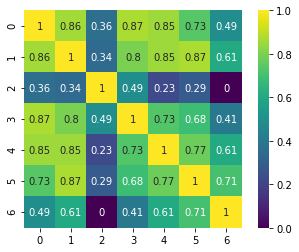

In [43]:
cov_mat_clust = 1-(dist_mat_clust)/np.max(dist_mat_clust)
pd.DataFrame(cov_mat_clust)
sns.heatmap(cov_mat_clust, square=True, cmap='viridis', annot=True)

In [45]:
log_area_s = shared(data_isl['NORM_LOG_AREA'].values)
cluster_s = shared(data_isl['cluster'].values)
N_clusters = len(data_isl['cluster'].unique())

with pm.Model() as model_pooled_multivar:
    #a = pm.Normal('a',0,2)
    intercept = pm.Normal('int',0,2)
    sigma = pm.HalfCauchy('sigma',1)
    mu = pm.Normal('mu',0,2, shape=N_clusters)
    
    mv_islands = pm.MvNormal('mv_isl', mu=mu, cov=cov_mat_clust, shape=(2,N_clusters))
    
    y = pm.Normal('y', observed = data_isl['NORM_NATIVE'].values, 
                  mu=mv_islands[0,:][cluster_s]+mv_islands[1,:][cluster_s]*log_area_s,
                  sd=sigma)

    trace_multivar = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:24<00:00, 140.85it/s]


In [74]:
pm.traceplot(trace_multivar)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B13042C7B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001B12C86BB00>]], dtype=object)

In [46]:
X0 = trace_multivar[mv_islands][:,0,:].mean(axis=0)
X1 = trace_multivar[mv_islands][:,1,:].mean(axis=0)

In [47]:
plt.figure(figsize=(12,4))
z=np.linspace(-2,3,2)
colors_list = [colors[c] for c in data_isl.cluster]

for i in range(N_clusters):
    plt.plot(z,X0[i]+X1[i]*z, color=colors[i], alpha=.7)
plt.scatter(data_isl['NORM_NATIVE'].values,data_isl['NORM_LOG_AREA'].values, marker='1', label='observed data', c=colors_list,s = 60)
plt.xlabel('normalized log(area island)')
plt.ylabel('normalized native species')
plt.xlim(z)
plt.legend()
plt.show()

In [50]:
cl_data = data_isl.sort_values(by='cluster').reset_index(drop=True)
colors_list = [colors[c] for c in cl_data.cluster]

plt.figure(figsize=(12,4))
plt.suptitle('predicted vs effective number of species per island - GP model', y=.949)
plt.scatter(np.arange(len(cl_data)),normed['NATIVE'].denormalize(X0[cl_data.cluster]+X1[cl_data.cluster]*cl_data.NORM_LOG_AREA), c=colors_list)
plt.scatter(np.arange(len(data_isl)),cl_data.NATIVE, c='black', alpha=.2, marker='1', label='actual values')

plt.xticks(range(len(cl_data.ISLAND.values)), cl_data.ISLAND.values, rotation=-90)
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors_list,ax.xaxis.get_ticklabels())]

plt.hlines(normed['NATIVE'].denormalize(np.mean(X0[cl_data.cluster]+X1[cl_data.cluster]*cl_data.NORM_LOG_AREA)),-1,len(data_isl)+1, 
           linestyles="--", linewidth=1, alpha=.2, label='mean predicted value')
plt.ylim((None,120))
plt.legend(loc=2, framealpha=0)
plot_images(plt, '4_33') 

In [53]:
traces = [trace_multivar, trace]
pm_models = [model_pooled_multivar, model_pooled]
models = ['GP model for clusters','fully pooled']

comparison = pm.compare(traces,pm_models)
models_ix = [models[a] for a in comparison.index]
comparison.index = models_ix
comparison

dic_loo = pd.DataFrame([[pm.dic(traces[i],pm_models[i]) for i in range(len(traces))],
              [pm.loo(traces[i],pm_models[i])[0] for i in range(len(traces))]], 
                       columns=models, index=['DIC','loo']).T

pd.merge(comparison, dic_loo, left_index=True, right_index=True)

C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


WAIC pWAIC dWAIC weight    SE   dSE warning  \
GP model for clusters  41.37  9.61     0    0.6  8.16     0       1   
fully pooled           43.73  3.69  2.36    0.4  9.61  8.39       1   

                              DIC        loo  
GP model for clusters  106.094551  47.539676  
fully pooled            52.077827  44.414644

# GP for islands

In [72]:
from geopy.distance import vincenty
N_isl = len(data_isl)
dist_mat_isl = np.zeros((N_isl,N_isl))

for n, i in enumerate(data_isl.ISLAND):
    a = (data_isl.loc[data_isl.ISLAND==i,'lat'].values,data_isl.loc[data_isl.ISLAND==i,'lon'].values)
    for k, j in enumerate(data_isl.ISLAND):
        b = (data_isl.loc[data_isl.ISLAND==j,'lat'].values,data_isl.loc[data_isl.ISLAND==j,'lon'].values)
        dist_mat_isl[n,k] = vincenty(a, b).km

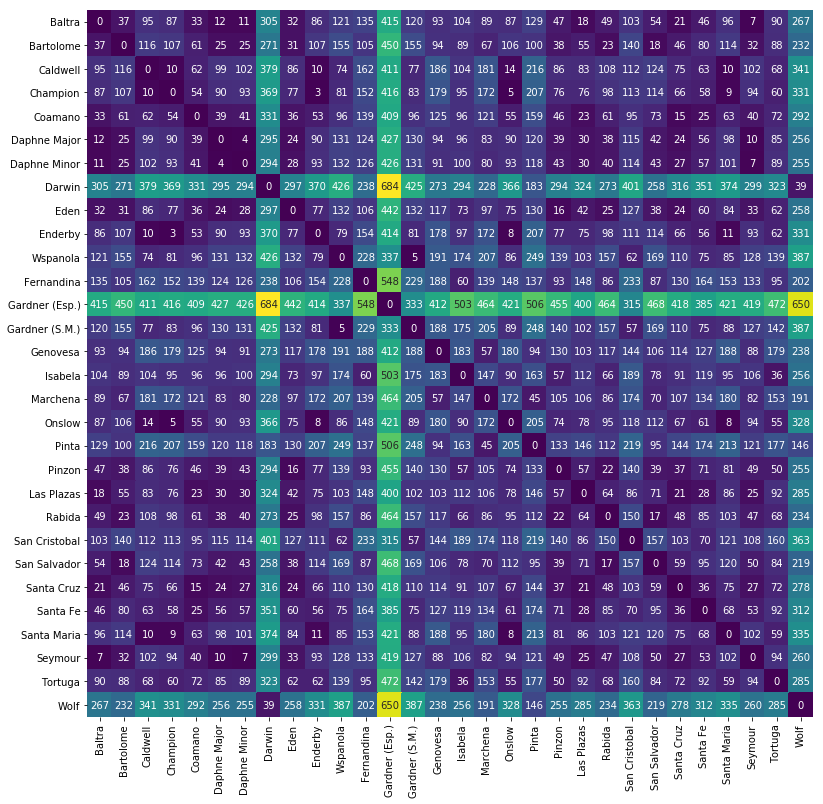

In [73]:
plt.figure(figsize=(13,13))

sns.heatmap(pd.DataFrame(np.round(dist_mat_isl,0),index=data_isl.ISLAND.values, 
                         columns=data_isl.ISLAND.values), cmap='viridis',
           annot=True, cbar=0, fmt='.3g')

In [79]:
log_area_s = shared(data_isl['NORM_LOG_AREA'].values)
isl_ix_s = shared(data_isl.index.values)
N_isl = len(data_isl)
cov_mat_isl = 1-(dist_mat_isl)/np.max(dist_mat_isl)



with pm.Model() as model_pooled_multivar_isl:
    sigma = pm.HalfCauchy('sigma',1)
    hyper_mu_int = pm.Normal('hm_int',0,1)
    hyper_sd_int = pm.Uniform('hs_int',0,10)

    intercept = pm.Normal('int',hyper_mu_int,hyper_sd_int)
    mv_islands = pm.MvNormal('mv_isl', mu=np.zeros(N_isl), cov=cov_mat_isl, shape=(2,N_isl))
    
    y = pm.Normal('y', observed = data_isl['NORM_NATIVE'].values, 
                  mu=intercept+mv_islands[0,:][isl_ix_s]+mv_islands[1,:][isl_ix_s]*log_area_s,
                  sd=sigma)

    trace_multivar_isl = pm.sample(3000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████████████████████████████████████████████████████████████████████████▉| 3497/3500 [01:21<00:00, 42.70it/s]C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 165 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [01:21<00:00, 42.71it/s]


In [81]:
pm.traceplot(trace_multivar_isl)
plt.show()

In [82]:
X0 = trace_multivar_isl[mv_islands][:,0,:].mean(axis=0)
X1 = trace_multivar_isl[mv_islands][:,1,:].mean(axis=0)
inter = trace_multivar_isl['int'].mean(axis=0)

In [83]:
import matplotlib.cm as cm

plt.figure(figsize=(12,4))
z=np.linspace(-2,3,2)
colors_list=cm.viridis(np.linspace(.1,.9,len(data_isl)))

for i in range(N_isl):
    plt.plot(z,inter+X0[i]+X1[i]*z,  alpha=.3, color=colors_list[i])
plt.scatter(data_isl['NORM_NATIVE'].values,data_isl['NORM_LOG_AREA'].values, marker='1', label='observed data',s = 60, color=colors_list)
plt.xlabel('normalized log(area island)')
plt.ylabel('normalized native species')
plt.xlim(z)
plt.legend()
plt.show()

In [84]:
plt.figure(figsize=(13,13))

sns.heatmap(pd.DataFrame(cov_mat_isl, index=data_isl.ISLAND.values, columns=data_isl.ISLAND.values)
, square=0, cmap='viridis', annot=True, vmin=0, vmax=1, cbar=0)

plt.show()

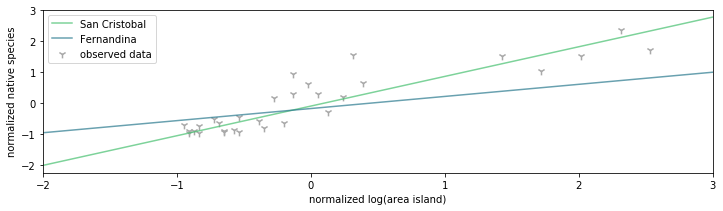

In [85]:
plt.figure(figsize=(12,3))
z=np.linspace(-2,3,2)
for i in [22,11]:
    plt.plot(z,inter+X0[i]+X1[i]*z,  alpha=.7, label=data_isl.ISLAND[i], color=colors_list[i])
plt.scatter(data_isl['NORM_NATIVE'].values,data_isl['NORM_LOG_AREA'].values, marker='1', label='observed data',s = 60, 
            color='darkgrey')
plt.xlabel('normalized log(area island)')
plt.ylabel('normalized native species')
plt.xlim(z)
plt.legend()
plot_images(plt, '4_34') 

In [86]:
plt.figure(figsize=(12,3))
z=np.linspace(-2,3,2)
for i in [26,17]:
    plt.plot(z,inter+X0[i]+X1[i]*z,  alpha=.7, label=data_isl.ISLAND[i], color=colors_list[i])
plt.scatter(data_isl['NORM_NATIVE'].values,data_isl['NORM_LOG_AREA'].values, marker='1', label='observed data',s = 60, 
            color='darkgrey')
plt.xlabel('normalized log(area island)')
plt.ylabel('normalized native species')
plt.xlim(z)
plt.legend()
plt.show()

In [89]:
plt.figure(figsize=(12,3))
z=np.linspace(-2,3,2)
for i in [26,28]:
    plt.plot(z,inter+X0[i]+X1[i]*z,  alpha=.7, label=data_isl.ISLAND[i], color=colors_list[i])
plt.scatter(data_isl['NORM_NATIVE'].values,data_isl['NORM_LOG_AREA'].values, marker='1', label='observed data',s = 60, 
            color='darkgrey')
plt.xlabel('normalized log(area island)')
plt.ylabel('normalized native species')
plt.xlim(z)
plt.legend()
plot_images(plt, '4_35') 

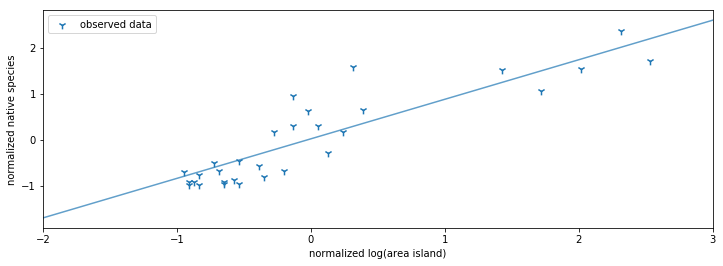

In [90]:
plt.figure(figsize=(12,4))
z=np.linspace(-2,3,2)

plt.plot(z,X0.mean()+X1.mean()*z+inter,  alpha=.7)
plt.scatter(data_isl['NORM_NATIVE'].values,data_isl['NORM_LOG_AREA'].values, marker='1', label='observed data',s = 60)
plt.xlabel('normalized log(area island)')
plt.ylabel('normalized native species')
plt.xlim(z)
plt.legend()
plt.show()

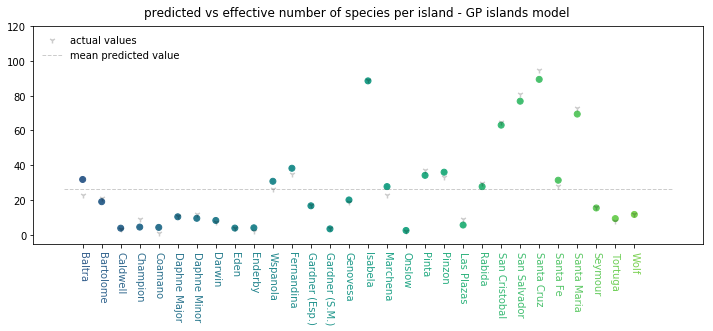

In [91]:
cl_data = data_isl
from matplotlib.pyplot import cm 
colors_list=cm.viridis(np.linspace(.3,.8,30))
prediction = inter+X0[cl_data.index.values]+X1[cl_data.index.values]*cl_data.NORM_LOG_AREA

plt.figure(figsize=(12,4))
plt.suptitle('predicted vs effective number of species per island - GP islands model', y=.949)
plt.scatter(np.arange(len(cl_data)),normed['NATIVE'].denormalize(prediction), c=colors_list)
plt.scatter(np.arange(len(data_isl)),cl_data.NATIVE, c='black', alpha=.2, marker='1', label='actual values')

plt.xticks(range(len(cl_data.ISLAND.values)), cl_data.ISLAND.values, rotation=-90)
ax = plt.gca()
[t.set_color(i) for (i,t) in zip(colors_list,ax.xaxis.get_ticklabels())]

plt.hlines(normed['NATIVE'].denormalize(np.mean(prediction)),-1,len(data_isl)+1, 
           linestyles="--", linewidth=1, alpha=.2, label='mean predicted value')
plt.ylim((None,120))
plt.legend(loc=2, framealpha=0)
plot_images(plt, '4_36') 

In [95]:
traces = [trace,trace_np,trace_pp, trace_multivar, trace_multivar_isl]
pm_models = [model_pooled,model_no_pooling,model_partial_pooling, model_pooled_multivar, model_pooled_multivar_isl]
models = ['fully pooled', 'non-pooled', 'partial-pooled','GPcluster','GPisland']

comparison = pm.compare(traces,pm_models)
models_ix = [models[a] for a in comparison.index]
comparison.index = models_ix

dic_loo = pd.DataFrame([[pm.dic(traces[i],pm_models[i]) for i in range(len(traces))],
              [pm.loo(traces[i],pm_models[i])[0] for i in range(len(traces))]], 
                       columns=models, index=['DIC','loo']).T

pd.merge(comparison, dic_loo, left_index=True, right_index=True).drop(labels=['SE','dSE','warning'])

C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\stats.py:285: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is
        because importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


WAIC  pWAIC  dWAIC weight    SE   dSE warning         DIC  \
GPisland         9.79  15.11      0      1   4.6     0       1   67.193059   
partial-pooled  40.14   8.41  30.34      0  8.26  6.57       1   67.167622   
GPcluster       41.37   9.61  31.58      0  8.16  6.89       1  106.094551   
fully pooled    43.73   3.69  33.94      0  9.61  8.02       1   52.077827   
non-pooled      44.18  10.15  34.38      0  7.48  6.41       1   97.790929   

                      loo  
GPisland        19.356418  
partial-pooled  43.879732  
GPcluster       47.539676  
fully pooled    44.414644  
non-pooled      50.832437

# extra: OOS comparison

In [100]:
log_area_s = shared(data_isl_train['NORM_LOG_AREA'].values)
cluster_s = shared(data_isl_train['cluster'].values)
N_clusters = len(data_isl['cluster'].unique())

with pm.Model() as model_pp_oos:
    hyper_mu_a = pm.Normal('hm_a',0,1)
    hyper_sd_a = pm.Uniform('hs_a',0,10)
    hyper_mu_int = pm.Normal('hm_int',0,1)
    hyper_sd_int = pm.Uniform('hs_int',0,10)

    a = pm.Normal('a',hyper_mu_a,hyper_sd_a, shape=N_clusters)
    intercept = pm.Normal('int',hyper_mu_int,hyper_sd_int, shape=N_clusters)
    sigma = pm.HalfCauchy('sigma',1)
    y = pm.Normal('y', observed = data_isl_train['NORM_NATIVE'].values, 
                  mu=intercept[cluster_s]+a[cluster_s]*log_area_s,
                  sd=sigma)

    trace_pp_oos = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████████████████████████████████████████████▋| 3485/3500 [00:14<00:00, 241.72it/s]C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 166 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:14<00:00, 241.58it/s]


In [101]:
with pm.Model() as model_fp_oos:
    a = pm.Normal('a',0,2)
    intercept = pm.Normal('int',0,2)
    sigma = pm.HalfCauchy('sigma',1)
    y = pm.Normal('y', observed = data_isl_train['NORM_NATIVE'].values, 
                  mu=intercept+a*log_area_s,
                  sd=sigma)

    trace_fp_oos = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:01<00:00, 1752.20it/s]


In [102]:
from pymc3 import sample_ppc

log_area_s.set_value(data_isl_oos['NORM_LOG_AREA'].values)
cluster_s.set_value(data_isl_oos['cluster'].values)

with model_pp_oos:
    tr_pp_pred = sample_ppc(trace_pp_oos)

with model_fp_oos:
    tr_fp_pred = sample_ppc(trace_fp_oos)

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 3537.65it/s]


In [103]:
plt.figure(figsize=(6,6))
colors_list_oos = [colors[c] for c in data_isl_oos.cluster]

plt.scatter(normed['NATIVE'].denormalize(tr_pp_pred['y'].mean(axis=0)), data_isl_oos['NATIVE'].values, 
            label='partial-pooling out of sample estimate', marker='o', s=40, c=colors_list_oos)
plt.scatter(normed['NATIVE'].denormalize(tr_fp_pred['y'].mean(axis=0)), data_isl_oos['NATIVE'].values, 
            label='full pooling out of sample estimate', marker='x', s=40, c=colors_list_oos)

plt.plot([0,100],[0,100], ':', color='darkgrey')
plt.legend()
plt.suptitle("predicted vs actual values comparison", y=.94)
plt.ylabel('actual value')
plt.xlabel('predicted value')
plt.show()

In [104]:
denorm_trace_fp = normed['NATIVE'].denormalize(tr_fp_pred['y'])
denorm_trace_pp = normed['NATIVE'].denormalize(tr_pp_pred['y'])

In [105]:
denorm_trace_fp.mean(axis=0)

array([ 32.40645818,  40.21322068,  32.99186507,  64.21765653,
        11.10750627,   4.45769722])

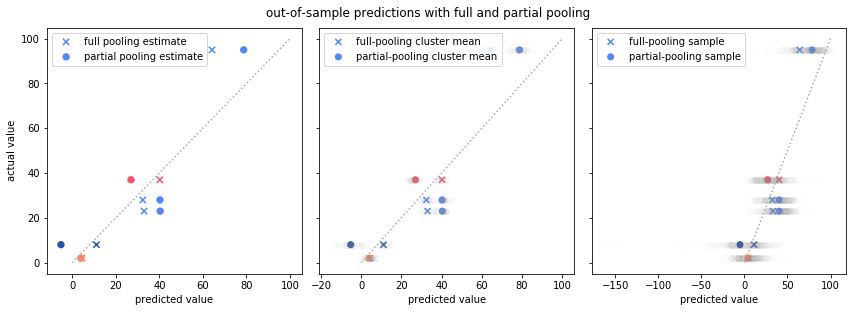

In [106]:
f, axes = plt.subplots(1,3,figsize=(12,4.2), sharey=True)
f.suptitle('out-of-sample predictions with full and partial pooling', y=1.02)
colors_list_oos = [colors[c] for c in data_isl_oos.cluster]

ax = axes[0]

ax.scatter(denorm_trace_fp.mean(axis=0), data_isl_oos['NATIVE'].values, 
            label='full pooling estimate', marker='x', s=40, c=colors_list_oos)
ax.scatter(denorm_trace_pp.mean(axis=0), data_isl_oos['NATIVE'].values, 
            label='partial pooling estimate', marker='o', s=40, c=colors_list_oos)

ax.plot([0,100],[0,100], ':', color='darkgrey')
ax.legend(loc=2)
ax.set_ylabel('actual value')
ax.set_xlabel('predicted value')




ax = axes[1]
CLUSTER = 40

ax.scatter(denorm_trace_fp.mean(axis=0), data_isl_oos['NATIVE'].values, c=colors_list_oos,
           alpha=1, marker='x', label='full-pooling cluster mean')
for j in range(100,1000,CLUSTER):
    ax.scatter(denorm_trace_fp[j:j+CLUSTER].mean(axis=0), data_isl_oos['NATIVE'].values, color='darkgrey',alpha=.03, marker='x')

ax.scatter(denorm_trace_pp.mean(axis=0), data_isl_oos['NATIVE'].values, c=colors_list_oos, 
           alpha=1, marker='o', label='partial-pooling cluster mean')
for j in range(100,1000,CLUSTER):
    ax.scatter(denorm_trace_pp[j:j+CLUSTER].mean(axis=0), data_isl_oos['NATIVE'].values, color='darkgrey',alpha=.03, marker='o')

ax.plot([0,100],[0,100], ':', color='darkgrey')
ax.legend(loc=2)
ax.set_xlabel('predicted value')



ax = axes[2]
CLUSTER = 1

ax.scatter(denorm_trace_fp.mean(axis=0), data_isl_oos['NATIVE'].values, c=colors_list_oos,
           alpha=1, marker='x', label='full-pooling sample')
for j in range(500,600,CLUSTER):
    ax.scatter(denorm_trace_fp[j:j+CLUSTER].mean(axis=0), data_isl_oos['NATIVE'].values, color='darkgrey',alpha=.02, marker='x')

ax.scatter(denorm_trace_pp.mean(axis=0), data_isl_oos['NATIVE'].values, c=colors_list_oos, 
           alpha=1, marker='o', label='partial-pooling sample')
for j in range(500,600,CLUSTER):
    ax.scatter(denorm_trace_pp[j:j+CLUSTER].mean(axis=0), data_isl_oos['NATIVE'].values, color='darkgrey',alpha=.02, marker='o')

ax.plot([0,100],[0,100], ':', color='darkgrey')
ax.legend(loc=2)
ax.set_xlabel('predicted value')

plt.tight_layout()
plt.show()


In [107]:
def mse(y,ypred):
    return np.sum((y-ypred)**2/len(y))

print(mse(normed['NATIVE'].denormalize(tr_pp_pred['y']).mean(axis=0), data_isl_oos['NATIVE'].values), 'MSE partial pool')
print(mse(normed['NATIVE'].denormalize(tr_fp_pred['y']).mean(axis=0), data_isl_oos['NATIVE'].values), 'MSE full pooling')


165.796227946 MSE partial pool
182.138094783 MSE full pooling
